In [22]:
import sys
sys.path.insert(0, "..")
from pathlib import Path
import re
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.collections as mc
import matplotlib.cm as cm

In [23]:
BASE_DIR = Path("./storage")

job_dirs=(
    # "ac8e2f77-0:169320.nqsv",
    # "be8a9a9d-0:169320.nqsv",
    # "b6bfc7d2-0:169350.nqsv",
    # "9f33a6da-0:169350.nqsv",
    # "dcc3d009-0:169350.nqsv",
    # "fca82248-0:169350.nqsv",
    # "827b4b75-0:169365.nqsv",
    # "af39e8e7-0:169426.nqsv",
    # "0a7cf6b3-0:169450.nqsv",
    # "d0719ee7-0:169450.nqsv",
    # "6a331f40-0:169450.nqsv",
    # "0178917a-0:169450.nqsv",
)

re_io = re.compile(r'^\[([0-9]+)/([0-9]+)\]\s+(writing|reading) \(buf = [^,]+, loc = ([0-9]+), sz = ([0-9]+)\)', flags=re.MULTILINE)
re_open = re.compile(r'^\[([0-9]+)/([0-9]+)\] ADIOI_[^_]+_Open called on (.*)$', flags=re.MULTILINE)

io_logs = []
# for job_dir in job_dirs:
for job_dir in BASE_DIR.iterdir():
    if not job_dir.is_dir():
        continue
    stdout_file = BASE_DIR / job_dir / "stdout"
    stdout_file = job_dir / "stdout"
    print(stdout_file)

    current_open_file = {}
    with stdout_file.open() as f:
        for no,line in enumerate(f):
            m = re_open.match(line)
            if m:
                current_open_file[m.group(1)] = m.group(3)
            m = re_io.match(line)
            if m:
                io_logs.append((job_dir,) + m.groups() + (current_open_file[m.group(1)],))

df_src = (
    pd.DataFrame
        .from_records(
            io_logs,
            columns=['job', 'rank', 'world_size', 'ops', 'offset', 'size', 'file'])
        .astype({
            'job': str,
            'rank': int,
            'world_size': int,
            'ops': str,
            'offset': int,
            'size': int,
            'file': str,
        })
)

storage/7eaf46f2-0:169489.nqsv/stdout
storage/46803592-0:169489.nqsv/stdout


In [24]:
pd.set_option('display.max_rows', 50)
df = df_src

(
    df
    .query("ops == 'writing'")
    .query(f"rank == 0")
)


,job,rank,world_size,ops,offset,size,file
41020,storage/46803592-0:169489.nqsv,0,4,writing,2104,131072,storage/test.h5
41024,storage/46803592-0:169489.nqsv,0,4,writing,528440,131072,storage/test.h5
41033,storage/46803592-0:169489.nqsv,0,4,writing,1052728,131072,storage/test.h5
41038,storage/46803592-0:169489.nqsv,0,4,writing,1577016,131072,storage/test.h5
41043,storage/46803592-0:169489.nqsv,0,4,writing,2101304,131072,storage/test.h5
...,...,...,...,...,...,...,...
41231,storage/46803592-0:169489.nqsv,0,4,writing,1504,328,storage/test.h5
41232,storage/46803592-0:169489.nqsv,0,4,writing,136,544,storage/test.h5
41233,storage/46803592-0:169489.nqsv,0,4,writing,680,120,storage/test.h5
41234,storage/46803592-0:169489.nqsv,0,4,writing,0,96,storage/test.h5


storage/46803592-0:169489.nqsv


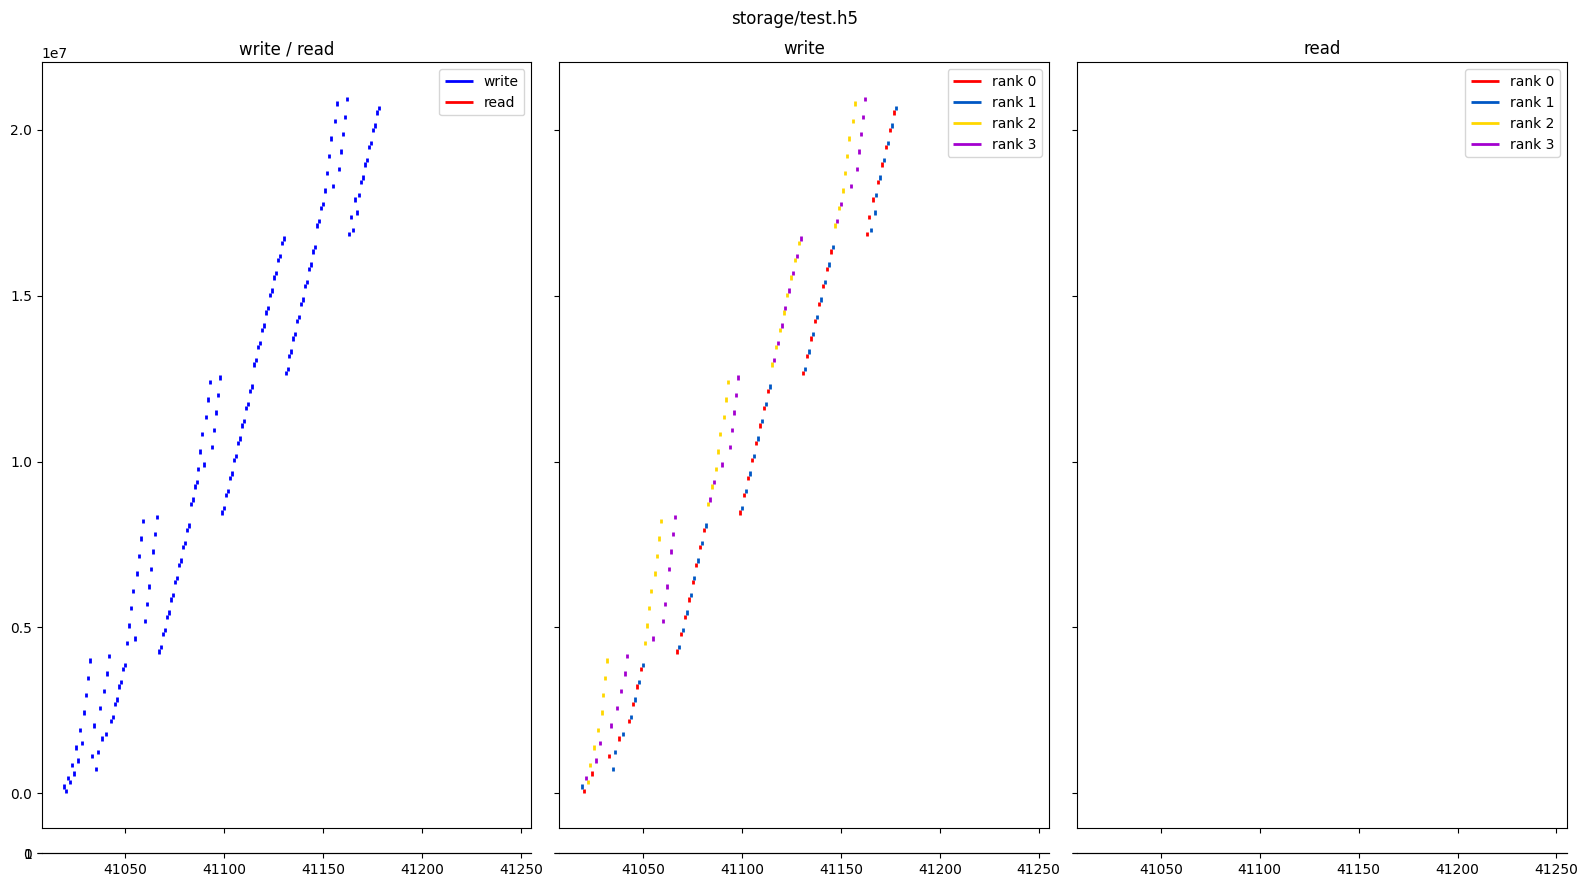

storage/7eaf46f2-0:169489.nqsv


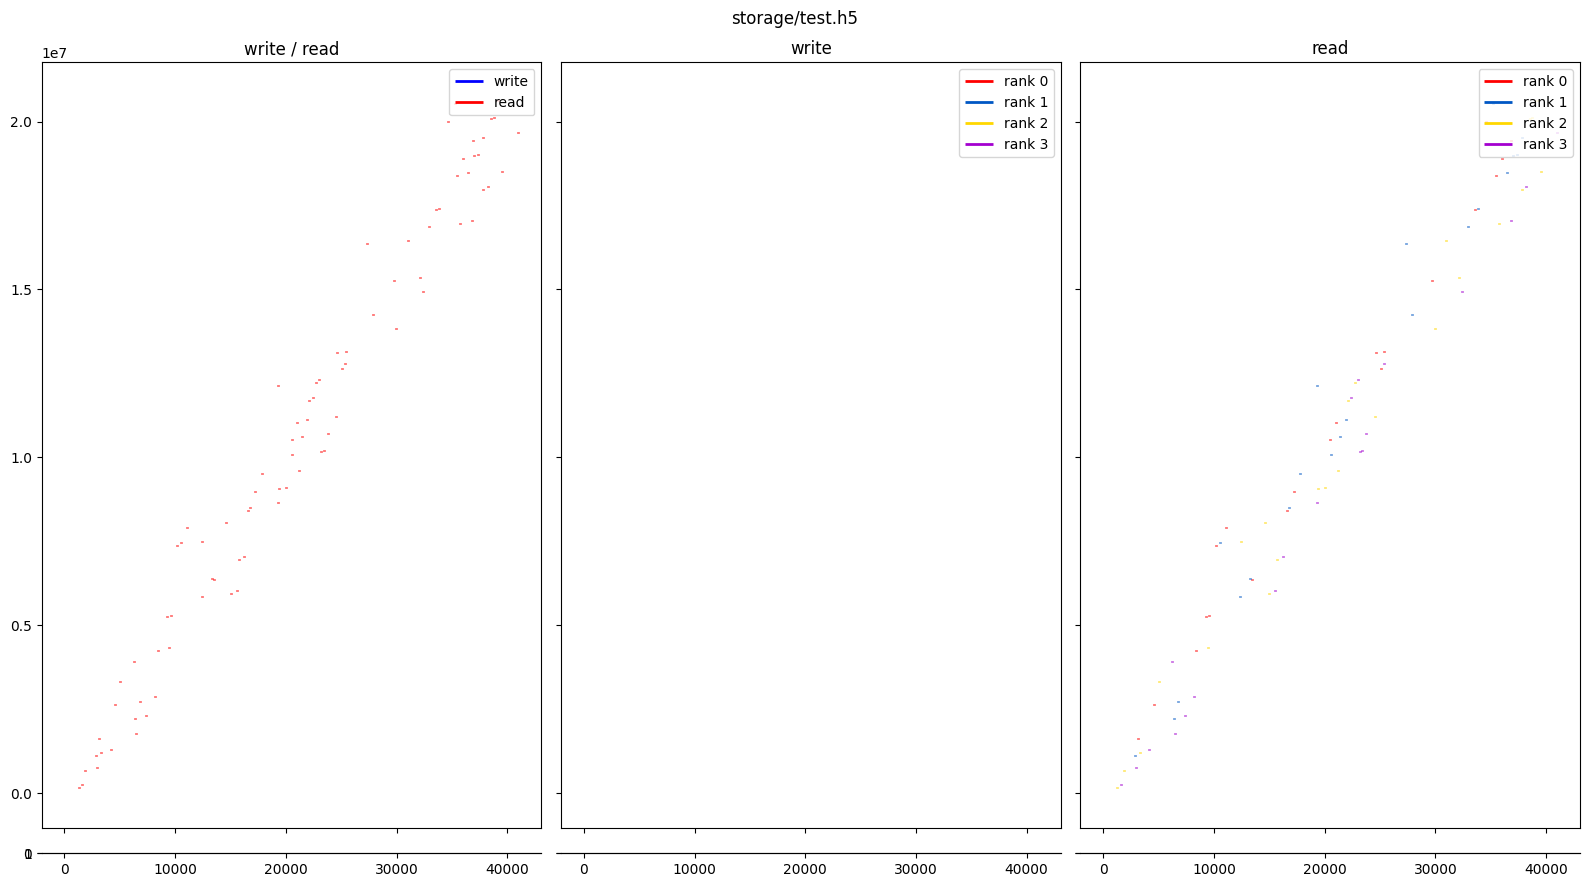

In [25]:
def plot_logs(df_in: pd.DataFrame, file: str):
    for idx,df in df_in.query(f'file == "{file}"').groupby("job"):
        print(idx)
        fig, axs = plt.subplots(2, 3, gridspec_kw={'height_ratios': [3, 0]}, sharex=True, figsize=(16, 9))
        # fig, axs = plt.subplots(1, 3, figsize=(8, 6))
        fig.set_dpi(100)
        fig.subplots_adjust(hspace=0, wspace=0)
        fig.suptitle(file)

        ax, axw, axr = axs[0]

        max_rank = df['rank'].max().item()

        for ops,color,axc in [('writing', 'blue', axw), ('reading', 'red', axr)]:
            lines = [[(int(row.Index), row.offset), (int(row.Index), row.offset + row.size)]
            for row in df[df['ops'] == ops].itertuples()
            ]
            lc = mc.LineCollection(lines, colors=color, linewidth=2)
            ax.add_collection(lc)

            for rank in range(0, max_rank+1):
                lines = [[(int(row.Index), row.offset), (int(row.Index), row.offset + row.size)]
                for row in df[(df['ops'] == ops) & (df['rank'] == rank)].itertuples()
                ]
                lc = mc.LineCollection(lines, colors=cm.prism(rank/(max_rank+1)), linewidth=2)
                axc.add_collection(lc)


        ax.autoscale()
        # ax.set_ylim(bottom=0, top=3*1024)
        # ax.set_ylim(bottom=0, top=512*1024*10)
        axw.set_xlim(ax.get_xlim())
        axr.set_xlim(ax.get_xlim())
        axw.set_ylim(ax.get_ylim())
        axr.set_ylim(ax.get_ylim())
        ax.set_title('write / read')
        axw.set_title('write')
        axr.set_title('read')
        ax.legend(['write', 'read'])
        axw.legend([f'rank {rank}' for rank in range(max_rank+1)], loc='best')
        axr.legend([f'rank {rank}' for rank in range(max_rank+1)], loc='best')
        for ax in axs[:,1:].flatten():
            ax.tick_params(labelleft=False)

        plt.tight_layout()
        fig.show()
        plt.show()


plot_logs(df_src, 'storage/test.h5')
plot_logs(df_src, 'storage/hdf5_iotest.h5')
# for file in df_src.file.unique():
#     plot_logs(df_src, file)